In [83]:
import torch
import astroddpm
from astroddpm.diffusion.stochastic import sde
from astroddpm.diffusion.models import network
from astroddpm.diffusion import dm
from astroddpm.datahandler.dataset import NPDataset, RandomRotate90
from astroddpm.diffusion.power_spectra import powerspec_sampler

from tqdm.notebook import tqdm
import os
from glob import glob

import matplotlib.pyplot as plt

In [84]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [85]:
## Load the dataset of numpy arrays (assume they are all individual images)
data_dir = '/mnt/home/dheurtel/ceph/01_data/CATS_I/'

dataset = NPDataset(dir = data_dir, transforms = RandomRotate90())

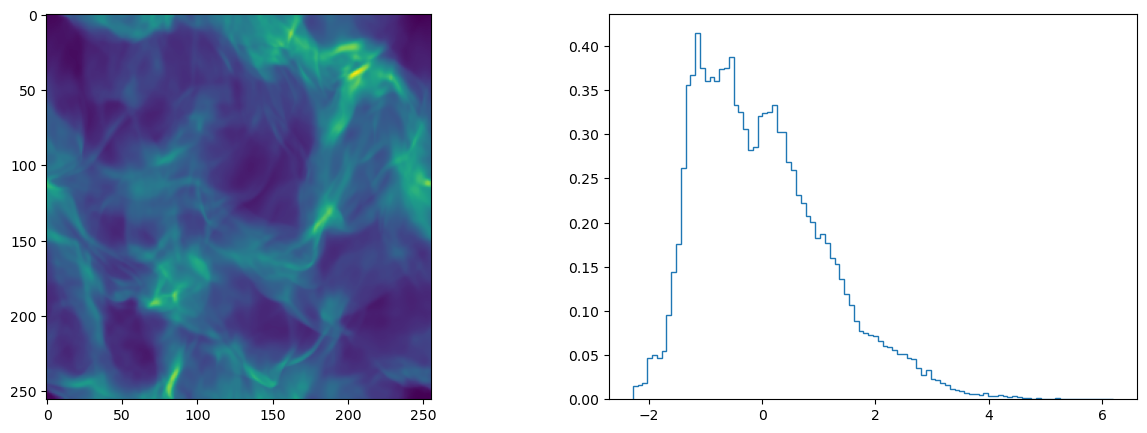

In [86]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
ax[0].imshow(dataset[0])
ax[1].hist(dataset[0].flatten(), bins = 100, histtype = 'step', density = True)
plt.show()

Define a SDE

In [87]:
continuous_vpsde = sde.ContinuousVPSDE(beta_min = 0.1, beta_max=20, t_min=1e-4, t_max = 1, beta_schedule = 'linear')

In [88]:
img = dataset[0].to(device).unsqueeze(0).unsqueeze(0)

In [89]:
T = 0.3
timesteps = T * torch.ones(img.shape[0], device = device, dtype = torch.float32)

In [90]:
noisy, mean, rescaled_added_noise = continuous_vpsde.sampling(img, timesteps)

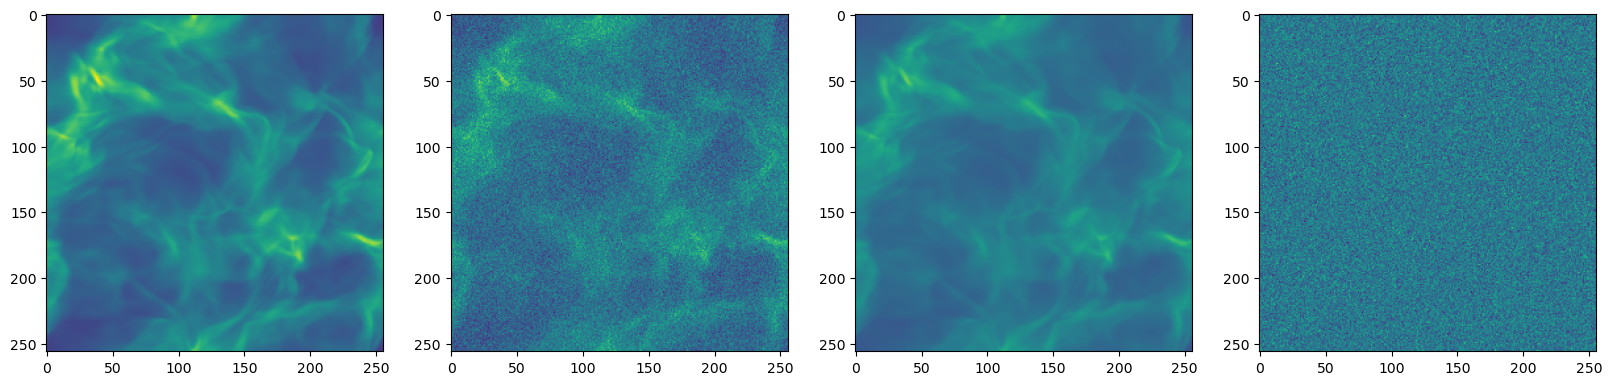

In [91]:
fig, ax = plt.subplots(1, 4, figsize = (20, 5))
vmin, vmax = torch.cat([img, noisy, mean, rescaled_added_noise]).min(), torch.cat([img, noisy, mean, rescaled_added_noise]).max()
ax[0].imshow(img.squeeze().cpu(), vmin = vmin, vmax = vmax) ## X_0
ax[1].imshow(noisy.squeeze().cpu(), vmin = vmin, vmax = vmax) ## Sample of X_t
ax[2].imshow(mean.squeeze().cpu(), vmin = vmin, vmax = vmax) ## Mean of X_t
ax[3].imshow(rescaled_added_noise.squeeze().cpu(), vmin = vmin, vmax = vmax) ## X_t - E[X_t] (rescaled)
plt.show()

What if we want the noise to have the same covariance as the CMB?

In [92]:
ps = powerspec_sampler.CMB_H_OMBH2().to(device)

In [93]:
ps_phi, phi = ps.sample_ps(img.shape[0])

Text(0.5, 1.0, "Power spectrum for phi : tensor([7.0332e+01, 4.5200e-02], device='cuda:0')")

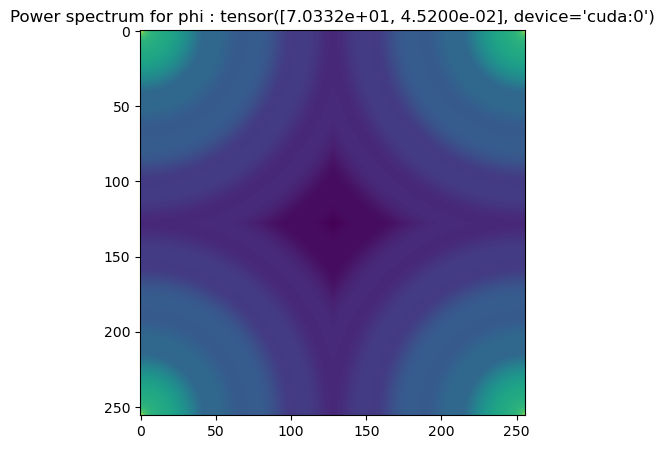

In [94]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5))

ax.imshow(torch.log(ps_phi[0][0].cpu()), label = 'phi')
ax.set_title('Power spectrum for phi : {}'.format(phi[0]))

Notice that the convention of not using fft shift for the power spectrum. (So the low frequencies are in the four corners.)

Now let's sample from the SDE but with CMB like noise

In [95]:
noisy, mean, rescaled_added_noise = continuous_vpsde.sampling(img, timesteps, sq_ps = torch.sqrt(ps_phi)) 
## Careful about the sqrt here

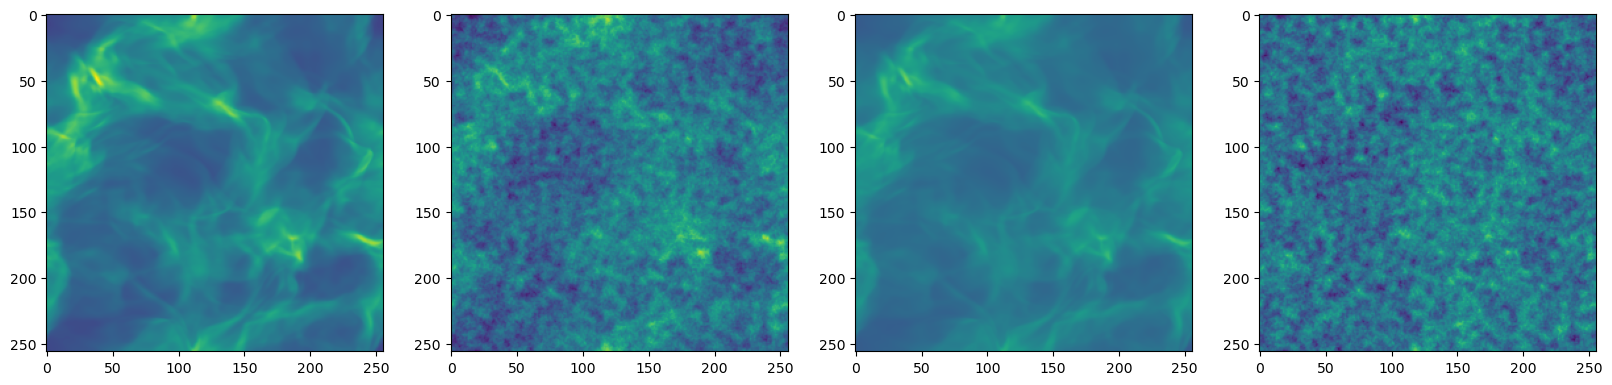

In [96]:
fig, ax = plt.subplots(1, 4, figsize = (20, 5))
vmin, vmax = torch.cat([img, noisy, mean, rescaled_added_noise]).min(), torch.cat([img, noisy, mean, rescaled_added_noise]).max()
ax[0].imshow(img.squeeze().cpu(), vmin = vmin, vmax = vmax) ## X_0
ax[1].imshow(noisy.squeeze().cpu(), vmin = vmin, vmax = vmax) ## Sample of X_t
ax[2].imshow(mean.squeeze().cpu(), vmin = vmin, vmax = vmax) ## Mean of X_t
ax[3].imshow(rescaled_added_noise.squeeze().cpu(), vmin = vmin, vmax = vmax) ## X_t - E[X_t] (rescaled)
plt.show()

Now let's define a network

In [97]:
net = network.ResUNet(in_c=1, ## Number of input channels
                      out_c=1, ## Number of output channels (same as input for any diffusion model)
                      first_c=10, ## Number of channels in the first layer of the network
                      sizes = [256, 128, 64, 32], ## Sizes of the different blocks of the network, channels are doubled at each block
                      num_blocks=1, ## Number of blocks for each size
                      time_emb_dim=100,  ## Dimension of the time embedding
                      dropout = 0, ## Dropout rate 
                      attention = [], ## Attention blocks, not used here
                      padding_mode='circular', ## Padding mode, circular for periodic boundary conditions
                      skiprescale=True,  ## Rescaling the skip connections of each block
                      discretization='continuous', ## Continuous or discrete time diffusion model
                      embedding_mode='fourier', ## Fourier or linear embedding for the time embedding
                      has_phi = True, ## If True, the model will learn to denoise a continuum of SDEs, parameterized by phi
                      phi_shape=2, ## Dimension of the parameter space of phi
                      phi_embed_dim=100, ## Dimension of the embedding of phi
                      )

In [98]:
## Test:
net = net.to(device)
out = net(img, timesteps, phi = phi)

In [99]:
out.shape

torch.Size([1, 1, 256, 256])

The network takes as input any noisy image, the timesteps that corresponds and some parameters if needed. It outputs an estimate of the noise that was added to the image (to be more precise, the rescaled_noise above)

In [100]:
## Train the network for a few epochs

In [101]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 64, shuffle = True)

In [102]:
## We have a wrapper for the diffusion model, which takes care of the relation between:
## - the network
## - the sde
## - a power spectrum sampler (optional) it may be:
##      - None for white noise
##      - a constant power spectrum object
##      - a power spectrum sampler, with parameters phi (see power_spectra.py for examples)
diffusion_model = dm.ContinuousSBM(continuous_vpsde, net, ps).to(device)

## It automatically freezes any parameter of the sde and the power spectrum sampler so that they are not trained

In [103]:
optimizer = torch.optim.Adam(diffusion_model.parameters(), lr = 1e-3)

In [104]:
num_epochs = 100
sample_every = 20
num_samples = 8

In [105]:
samples_list = []

In [106]:
progress_bar = tqdm(range(num_epochs))
for epoch in range(num_epochs):
    train_loss = 0
    n = len(dataset)
    for batch in dataloader:
        batch = batch.to(device).unsqueeze(1) ## Add channel dimension	
        optimizer.zero_grad()
        loss = diffusion_model.loss(batch) 
        ## 1. Samples ps_phi according to some prior 
        ## 2. Noises the image
        ## 3. Passes it through the network
        ## 4. Computes the denoising score matching loss to train the network (see Song et al. 2021)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch.shape[0]
    train_loss /= n
    log = {'epoch': epoch, 'train_loss': train_loss}
    progress_bar.set_postfix(log)
    progress_bar.update(1)
    if epoch % sample_every == 0 or epoch == num_epochs - 1:
        samples_list.append(diffusion_model.generate_image(num_samples)) ## Will generate some images for random phi

  0%|          | 0/100 [00:00<?, ?it/s]

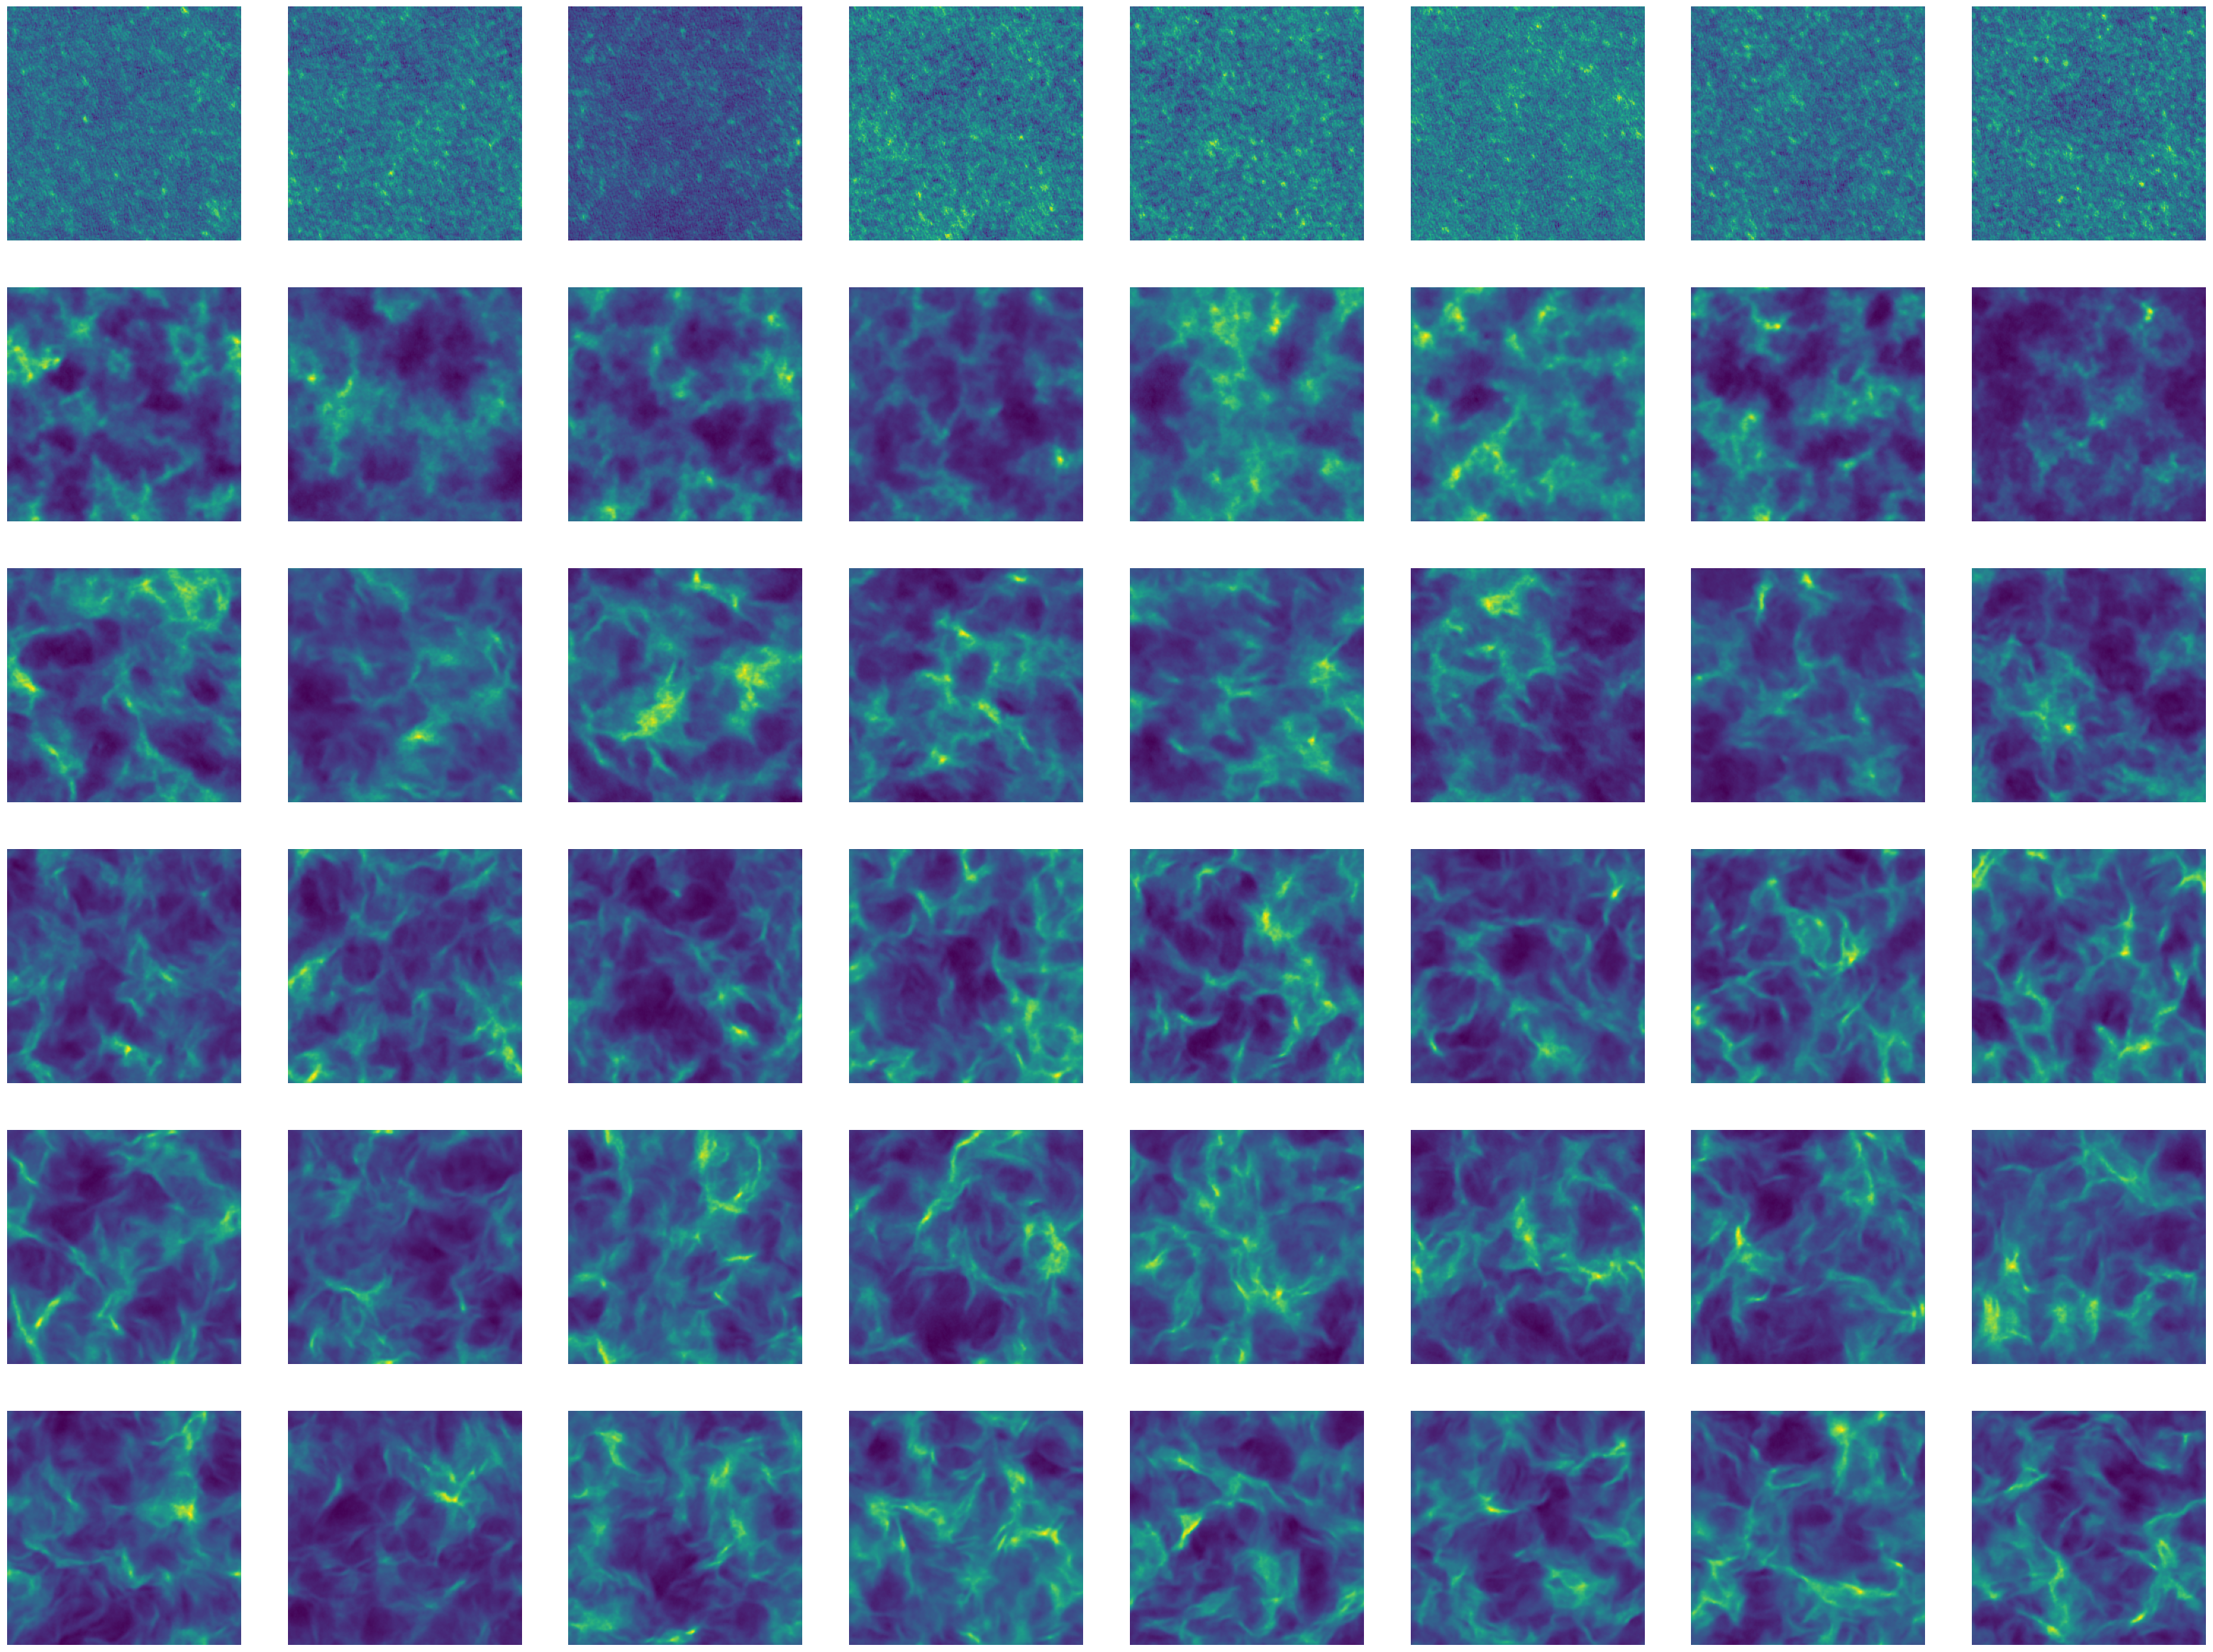

In [110]:
## Plot the samples at different epochs
fig, ax = plt.subplots(len(samples_list),num_samples, figsize = (5 * num_samples,5 * len(samples_list)))

for i, sample in enumerate(samples_list):
    for j, s in enumerate(sample):
        ax[i, j].imshow(s.squeeze().cpu())
        ax[i, j].axis('off')